In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn as sns
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

import scrublet as scr
import harmonypy as hm
import pickle
from random import sample
from matplotlib_venn import venn2

# Load single cell Data

In [2]:
#SG_DF = pd.read_pickle('./DAP3_SGRNA_IND_072821.pkl')

In [3]:
#CM_Cells = sc.read_h5ad('./DAP3_SC_CM_Pseudo_PHATE_Man_080521.h5ad')
CM_Ordered_Cells = CM_Cells[CM_Cells.obs['rank_pseudotime'].sort_values()]

# Load RNA Seq Data and RPKM Normalize

In [4]:
file_dir = './GSE76525/'

In [5]:
### Create sample name dictionary
sample_keys = pd.read_csv(file_dir + 'samples.txt', delimiter='\t', index_col=0).index
sample_values = pd.read_csv(file_dir + 'samples.txt', delimiter='\t', index_col=0)['condition'].tolist()
sample_values[2] = 'D01'

Sample_Dict = dict(zip(sample_keys,sample_values))

In [6]:
Read_List = []
Timepoint_List = []
for key in Sample_Dict.keys():
    s_reads = pd.read_csv(file_dir + key + '_feature_counts.txt', delimiter='\t', header=1, index_col=0, usecols=[0,5,6]).iloc[:,1].values.tolist()
    if sum(s_reads) == 0:
        continue
    rpm_factor = sum(s_reads)/1000000
    rpm_reads = [read/rpm_factor for read in s_reads]
    Read_List.append(rpm_reads)
    Timepoint_List.append(Sample_Dict[key])

In [7]:
### Load just one for values
Initial_DF = pd.read_csv(file_dir + key + '_feature_counts.txt', delimiter='\t', header=1, index_col=0, usecols=[0,5,6])

In [8]:
RPM_DF = pd.DataFrame(data = Read_List, index=Timepoint_List, columns=pd.read_csv(file_dir + 'SRR3084936_feature_counts.txt', delimiter='\t', header=1, index_col=0, usecols=[0,5,6]).index).T

In [9]:
RPKM_DF = RPM_DF.iloc[:,0:].div((Initial_DF['Length']/1000), axis=0)

In [10]:
### Average replicates
RPKM_DF = RPKM_DF.groupby(RPKM_DF.columns, axis=1).mean()

### RNA seq Linegraph

In [11]:
### Top 1000 enriched genes for each cluster
Cluster_0_Genes = CM_Cells.uns['rank_genes_r1.0']['names']['0'][0:1000].tolist()
Cluster_1_Genes = CM_Cells.uns['rank_genes_r1.0']['names']['1'][0:1000].tolist()
Cluster_2_Genes = CM_Cells.uns['rank_genes_r1.0']['names']['2'][0:1000].tolist()
Cluster_3_Genes = CM_Cells.uns['rank_genes_r1.0']['names']['3'][0:1000].tolist()

In [12]:
Combined_Genes = Cluster_0_Genes+Cluster_1_Genes+Cluster_2_Genes+Cluster_3_Genes

In [13]:
### Take top 100 unique enriched genes for each cluster 
Gene_Range = list(range(0,100))

Cluster_0_Unique = [i for i in Cluster_0_Genes if Combined_Genes.count(i) == 1]
Cluster_0_Unique = [Cluster_0_Unique[i] for i in Gene_Range]

Cluster_1_Unique = [i for i in Cluster_1_Genes if Combined_Genes.count(i) == 1]
Cluster_1_Unique = [Cluster_1_Unique[i] for i in Gene_Range]

Cluster_2_Unique = [i for i in Cluster_2_Genes if Combined_Genes.count(i) == 1]
Cluster_2_Unique = [Cluster_2_Unique[i] for i in Gene_Range]

Cluster_3_Unique = [i for i in Cluster_3_Genes if Combined_Genes.count(i) == 1]
Cluster_3_Unique = [Cluster_3_Unique[i] for i in Gene_Range]

In [14]:
overlap_gene = []
for gene in Cluster_0_Unique:
    if gene in RPKM_DF.index:
        overlap_gene.append(gene)
RPKM_DF_Cluster0 = RPKM_DF.loc[overlap_gene]

overlap_gene = []
for gene in Cluster_1_Unique:
    if gene in RPKM_DF.index:
        overlap_gene.append(gene)
RPKM_DF_Cluster1 = RPKM_DF.loc[overlap_gene]

overlap_gene = []
for gene in Cluster_2_Unique:
    if gene in RPKM_DF.index:
        overlap_gene.append(gene)
RPKM_DF_Cluster2 = RPKM_DF.loc[overlap_gene]

overlap_gene = []
for gene in Cluster_3_Unique:
    if gene in RPKM_DF.index:
        overlap_gene.append(gene)
RPKM_DF_Cluster3 = RPKM_DF.loc[overlap_gene]

In [15]:
FC_Gene_List = []

RPKM_DF_Cluster0_Div = RPKM_DF_Cluster0.div(RPKM_DF_Cluster0['D00'],axis=0)
FC_Gene_List.append(RPKM_DF_Cluster0_Div.mean())

RPKM_DF_Cluster1_Div = RPKM_DF_Cluster1.div(RPKM_DF_Cluster1['D00'],axis=0)
FC_Gene_List.append(RPKM_DF_Cluster1_Div.mean())

RPKM_DF_Cluster2_Div = RPKM_DF_Cluster2.div(RPKM_DF_Cluster2['D00'],axis=0)
FC_Gene_List.append(RPKM_DF_Cluster2_Div.mean())

RPKM_DF_Cluster3_Div = RPKM_DF_Cluster3.div(RPKM_DF_Cluster3['D00'],axis=0)
FC_Gene_List.append(RPKM_DF_Cluster3_Div.mean())

FC_DF = pd.DataFrame(data=FC_Gene_List)

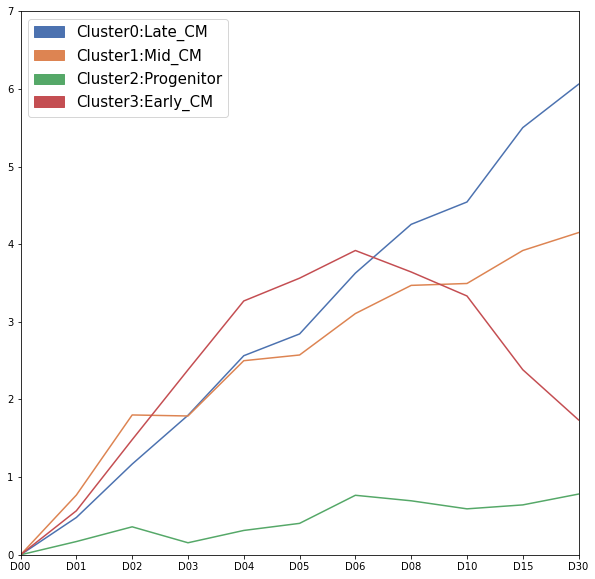

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

plt.plot(list(range(0,len(RPKM_DF.columns))),np.log2(FC_DF.iloc[:,0:]).loc[0].tolist(), color = '#4c72b0')

plt.plot(list(range(0,len(RPKM_DF.columns))),np.log2(FC_DF.iloc[:,0:]).loc[1].tolist(), color = '#dd8452')
    
plt.plot(list(range(0,len(RPKM_DF.columns))),np.log2(FC_DF.iloc[:,0:]).loc[2].tolist(), color = '#55a868')
    
plt.plot(list(range(0,len(RPKM_DF.columns))),np.log2(FC_DF.iloc[:,0:]).loc[3].tolist(), color = '#c44e52')

plt.xticks(list(range(len(RPKM_DF.columns))), RPKM_DF.columns)
patch0 = mpatches.Patch(color='#4c72b0', label='Cluster0:Late_CM')
patch1 = mpatches.Patch(color='#dd8452', label='Cluster1:Mid_CM')
patch2 = mpatches.Patch(color='#55a868', label='Cluster2:Progenitor')
patch3 = mpatches.Patch(color='#c44e52', label='Cluster3:Early_CM')

plt.legend(handles=[patch0,patch1,patch2, patch3], prop={'size': 15}, loc='upper left')
plt.xlim(0,10)
plt.ylim(0,7)
plt.show()
fig.savefig('./CM_RNAseq_081921.pdf')